# Map observed deltas to the FFT grid corresponding to a given redshift bin

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

### How to define the redshift bin and its associated FFT grid?

In [2]:
def top_hat_weight(z, z_alpha, dz=0.2):
    if (z<z_alpha-0.5*dz) or (z>z_alpha+0.5*dz):
        return 0
    else:
        return 1

In [3]:
def linear_weight(z, z_alpha, dz=0.2):
    if z>z_alpha:
        if z<z_alpha+dz:
            return (z_alpha+dz-z)/dz
        else:
            return 0
    else:
        if z>z_alpha-dz:
            return (z-z_alpha+dz)/dz
        else:
            return 0

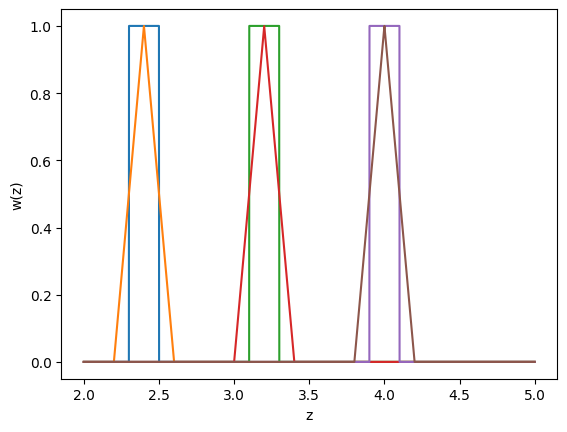

In [4]:
# visualization of the redshift bins, for top-hat and linear interpolations
zs=np.linspace(2.0,5.0,10000)
for z_alpha in [2.4, 3.2, 4.0]:
    th_w=[top_hat_weight(z, z_alpha) for z in zs]
    lin_w=[linear_weight(z, z_alpha) for z in zs]
    plt.plot(zs,th_w)
    plt.plot(zs,lin_w)
    plt.xlabel('z')
    plt.ylabel('w(z)')

In [5]:
# rest-frame wavelength of Lya (Angstroms)
lam_lya=1215.67
# speed of light, in km/s
c_kms=2.997e5
# pixel width, in Angstroms
pw_A = 0.8
# for now, use redshift bins of dz=0.2
dz=0.2
# delta lambda (observed wavelength) for a given bin (assuming top-hat redshift binning)
dlam_A=lam_lya*dz
print('Delta Lambda =',dlam_A, '[A]')
# number of pixels covered by the redshift bin (top-hat redshfit binning)
Np=round(dlam_A/pw_A)
print(Np, 'pixels in redshift bin')

Delta Lambda = 243.13400000000001 [A]
304 pixels in redshift bin


In [6]:
# length of the redshift bin in km/s, as a function of redshift
def bin_width_kms(z_alpha,dz=0.2):
    # this is just an approximation, but it should be good enough for this
    return c_kms*dz/(1+z_alpha)

Text(0, 0.5, '$r_\\parallel$ [km/s]')

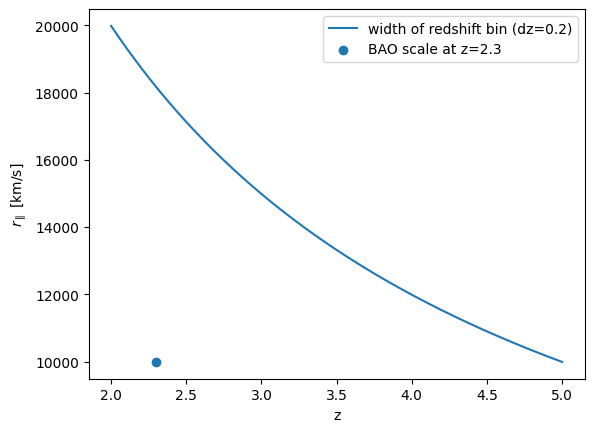

In [7]:
plt.plot(zs,bin_width_kms(zs,dz=0.2),label='width of redshift bin (dz=0.2)')
plt.scatter(x=2.3,y=1e4,label='BAO scale at z=2.3')
plt.legend()
plt.xlabel('z')
plt.ylabel('$r_\parallel$ [km/s]')

Ok, so it looks like at least at low-z the standard binning (dz=0.2) is large enough to capture most of the relevant information

In [8]:
# fundamental mode for a given (top hat) bin, in velocity units, as a function of redshift
def k0_kms(z_alpha,dz=0.2):
    dv_kms=bin_width_kms(z_alpha,dz)
    return 2*np.pi/dv_kms

Text(0, 0.5, 'k [s/km]')

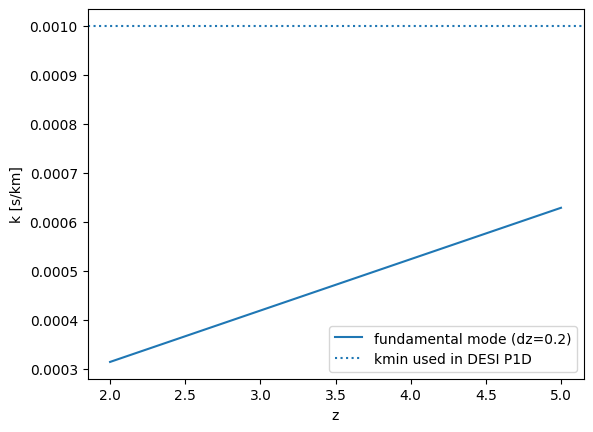

In [9]:
plt.plot(zs,k0_kms(zs,dz=0.2),label='fundamental mode (dz=0.2)')
plt.axhline(y=0.001,ls=':',label='kmin used in DESI P1D')
plt.legend()
plt.xlabel('z')
plt.ylabel('k [s/km]')

The fundamental mode from the standard binning is significantly smaller than the smaller scale used in P1D measurements, so this is good.

### Define the FFT associated to a given redshift bin

In [10]:
# First define the official DESI wavelength grid (all wavelengths that we could possibly care about)
wave_desi_N=5000
# I know for sure that there is a pixel at 3600A, so let's make sure we cover that one
wave_desi_min=3600-500*pw_A 
wave_desi_max=wave_desi_min+wave_desi_N*pw_A
print('{:.2f} < lambda < {:.2f} [A]'.format(wave_desi_min, wave_desi_max))
print('{:.3f} < z < {:.3f}'.format(wave_desi_min/lam_lya-1, wave_desi_max/lam_lya-1))
wave_desi=np.linspace(wave_desi_min,wave_desi_max,wave_desi_N+1)

3200.00 < lambda < 7200.00 [A]
1.632 < z < 4.923


Now, for every redshift bin, let's figure out which of the pixels above are covered by its FFT grid, and which weights do they receive

In [11]:
z_alpha=2.4
dz=0.2
# figure out the center of the bin and its edges, in observed wavelength
lam_cen=lam_lya*(1+z_alpha)
lam_min=lam_lya*(1+z_alpha-0.5*dz)
lam_max=lam_lya*(1+z_alpha+0.5*dz)
print(lam_min,lam_cen,lam_max)
# the FFT grid will have a fixed length of pixels (1024)
N_fft=1024
N_fft_2=1024//2
# figure out the index of the global (desi) grid that is closer to the center of the redshift bin
i_cen=round((lam_cen-wave_desi_min)/pw_A)
# initial wavelength (included)
i_min=i_cen-N_fft_2
# final wavelength (excluded)
i_max=i_cen+N_fft_2
print(i_cen,i_min,i_max)
# first wavelength in the FFT grid
wave_fft_grid=wave_desi[i_min:i_max]
print('wave_grid_min = {:.2f} [A]'.format(wave_desi[i_min]))
print('wave_grid_max = {:.2f} [A]'.format(wave_desi[i_max]))

4011.7110000000002 4133.278 4254.845
1167 655 1679
wave_grid_min = 3724.00 [A]
wave_grid_max = 4543.20 [A]


In [12]:
mask_fft_grid=np.ones(N_fft)
# while we use i to refer to indices in the global (desi) grid, we use j to refer to the FFT grid of this redshift
j_cen=round((lam_cen-wave_fft_grid[0])/pw_A)
# this should alway be N_fft/2
print(j_cen, N_fft_2)
# figure out the indices (in the FFT grid) that fall within the redshift bin (top hat binning)
j_min=round((lam_min-wave_fft_grid[0])/pw_A)
j_max=round((lam_max-wave_fft_grid[0])/pw_A)
mask_fft_grid[:j_min]=0
mask_fft_grid[j_max:]=0

512 512


Text(0.5, 1.0, 'FFT grid for bin z=2.40')

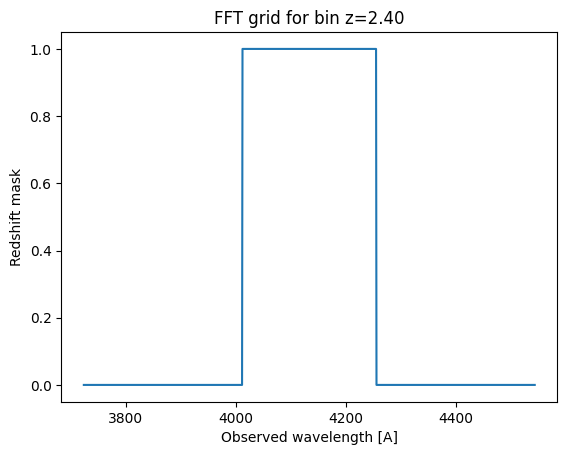

In [13]:
plt.plot(wave_fft_grid,mask_fft_grid)
plt.xlabel('Observed wavelength [A]')
plt.ylabel('Redshift mask')
plt.title('FFT grid for bin z={:.2f}'.format(z_alpha))

Now read an example delta field

In [14]:
deltas_path='/global/cfs/cdirs/desi/science/lya/mock_analysis/develop/ifae-ql/qq_desi_y3/v1.0.5/analysis-0/jura-124/raw_bao_unblinding/deltas_lya/Delta/'
delta_file=deltas_path+'delta-500.fits.gz'
file = fits.open(delta_file)

In [15]:
ihdu=1
# quasar meta data
z_qso=file[ihdu].header['Z']
RA=file[ihdu].header['RA']
Dec=file[ihdu].header['DEC']
# forest data
wave_data=10.0**(file[ihdu].data['LOGLAM'])
delta_data=file[ihdu].data['DELTA']
#weight_data=file[ihdu].data['WEIGHT']

Map the observed spectrum to the FFT grid for this particular redhsift bin

In [16]:
j_min_data=(wave_data[0]-wave_fft_grid[0])/pw_A
print('j_min ={:.8f}'.format(j_min_data))
j_min_data=round(j_min_data)
j_max_data=round((wave_data[-1]-wave_fft_grid[0])/pw_A)
print(j_min_data, j_max_data)

j_min =25.00000000
25 767


In [17]:
# map the data deltas into the FFT grid
delta_fft_grid=np.zeros(N_fft)
# figure out whether the spectrum is cut at low-z or at high-z
loz_cut=False
hiz_cut=False
if j_min_data < 0:
    loz_cut=True
    delta_fft_grid[:j_max_data]=delta_data[-j_min_data+1:]
if j_max_data >= N_fft:
    hiz_cut=True
    delta_fft_grid[j_min_data:]=delta_data[:N_fft-j_max_data-1]
if loz_cut==False and hiz_cut==False:
    delta_fft_grid[j_min_data:j_max_data+1]=delta_data

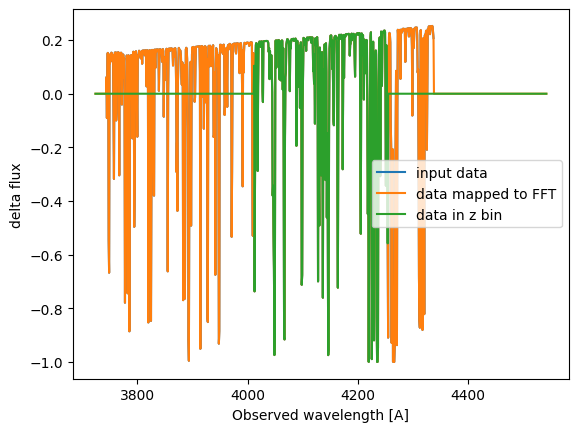

In [18]:
plt.plot(wave_data,delta_data,label='input data')
plt.plot(wave_fft_grid,delta_fft_grid,label='data mapped to FFT')
plt.plot(wave_fft_grid,delta_fft_grid*mask_fft_grid,label='data in z bin')
plt.xlabel('Observed wavelength [A]')
plt.ylabel('delta flux')
plt.legend()